In [1]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords,wordnet
from bs4 import BeautifulSoup
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [4]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [5]:
clean_tweet=[]
for sentence in tqdm(train['tweet'].values):
    sentence=re.sub(r"http\S+", "",sentence)
    sentence=re.sub("\S*@\S*\s?", "",sentence)
    sentence=BeautifulSoup(sentence,"lxml").get_text()
    sentence=re.sub("S*\d\S*","",sentence).strip()
    sentence=re.sub("[^A-Za-z0-9]"," ",sentence)
    sentence=" ".join(x.lower() for x in sentence.split() if x.lower() not in stopwords)
    clean_tweet.append(sentence.strip())

100%|██████████| 7920/7920 [00:01<00:00, 4426.31it/s]


In [6]:
clean_tweet_test=[]
for sentence in tqdm(test['tweet'].values):
    sentence=re.sub(r"http\S+", "",sentence)
    sentence=re.sub("\S*@\S*\s?", "",sentence)
    sentence=BeautifulSoup(sentence,"lxml").get_text()
    sentence=re.sub("S*\d\S*","",sentence).strip()
    sentence=re.sub("[^A-Za-z0-9]"," ",sentence)
    sentence=" ".join(x.lower() for x in sentence.split() if x.lower() not in stopwords)
    clean_tweet_test.append(sentence.strip())

100%|██████████| 1953/1953 [00:00<00:00, 4427.62it/s]


In [7]:
X=clean_tweet
y=np.array(train['label'])

In [8]:
Z=clean_tweet_test

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(ngram_range=(1,2),min_df=10)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
from sklearn import metrics

In [11]:
X_1,X_test,y_1,y_test=train_test_split(X,y,test_size=0.3,random_state=0)
X_train,X_cv,y_train,y_cv=train_test_split(X_1,y_1,test_size=0.3)

In [12]:
final_X_train=tfidf.fit_transform(X_train)
final_X_cv=tfidf.transform(X_cv)
final_X_test=tfidf.transform(X_test)

In [13]:
final_Z_test=tfidf.transform(Z)

In [14]:
from sklearn.linear_model import LogisticRegression

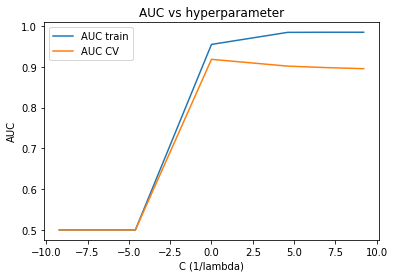

optimal lambda for which auc is maximum :  1


In [15]:
import math
C = [10**-4,10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda
auc_train=[]
auc_cv=[]
for c in C:
    lr=LogisticRegression(penalty='l1',C=c)
    lr.fit(final_X_train,y_train)
    probcv=lr.predict_proba(final_X_cv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,probcv))
    probtr=lr.predict_proba(final_X_train)[:,1]
    auc_train.append(roc_auc_score(y_train,probtr))
optimal_c= C[auc_cv.index(max(auc_cv))]
C=[math.log(x) for x in C]#converting values of C into logarithm
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(C, auc_train, label='AUC train')
ax.plot(C, auc_cv, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('C (1/lambda)')
plt.ylabel('AUC')
ax.legend()
plt.show()
print('optimal lambda for which auc is maximum : ',1//optimal_c)

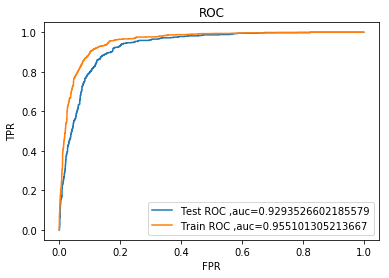

In [16]:
lr=LogisticRegression(penalty='l1',C=optimal_c)
lr.fit(final_X_train,y_train)
predi=lr.predict_proba(final_X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=lr.predict_proba(final_X_train)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix
lr=LogisticRegression(penalty='l1',C=optimal_c)
lr.fit(final_X_train,y_train)
predic=lr.predict(final_X_test)
cm=confusion_matrix(y_test,predic)
cm

array([[1662,  110],
       [ 231,  373]], dtype=int64)

In [18]:
acu=accuracy_score(y_test,predic)*100
acu

85.64814814814815

In [19]:
predicted=lr.predict(final_Z_test)
predicted

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [20]:
test['label']=predicted

In [21]:
test.head()

,id,tweet,label
0,7921,I hate the new #iphone upgrade. Won't let me d...,1
1,7922,currently shitting my fucking pants. #apple #i...,1
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t...",0
3,7924,My ipod is officially dead. I lost all my pict...,1
4,7925,Been fighting iTunes all night! I only want th...,0


In [22]:
final=test.drop('tweet',axis=1)

In [23]:
final

,id,label
0,7921,1
1,7922,1
2,7923,0
3,7924,1
4,7925,0
5,7926,1
6,7927,1
7,7928,0
8,7929,0
9,7930,0


In [24]:
final.to_csv('LRsol.csv',index=False)